# LIBRARIES

In [ ]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Image processing libraries
import cv2
import skimage
from skimage.transform import resize

# Scikit-learn for machine learning operations
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# TensorFlow and Keras for deep learning
import tensorflow as tf
from tensorflow import keras
from keras import utils, callbacks
from tensorflow.keras import utils
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import layers, models
from keras.layers import Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
from keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Metrics for evaluation
from sklearn import metrics


# DATA LOADING AND PREPROCESSING

In [ ]:
#Load the Dataset
dataset_path = "/content/data1"
class_names = sorted(os.listdir('/content/data1'))

In [ ]:
from os import listdir
total_signs=sorted(listdir("/content/data1"))
print(total_signs)

['test', 'train']


In [ ]:
import os
from collections import defaultdict
from matplotlib.image import imread

path = "//content/data1/train"
total_signs = os.listdir(path)

resolution_count = defaultdict(int)

for directory in total_signs:
    directory_path = os.path.join(path, directory)
    for filename in os.listdir(directory_path):
        image_path = os.path.join(directory_path, filename)
        try:
            img = imread(image_path)
            resolution = img.shape[:2]  # Extract resolution (height, width)
            resolution_count[resolution] += 1
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

print("Resolution Counts:")
for resolution, count in resolution_count.items():
    print(f"Resolution: {resolution}, Count: {count}")


Resolution Counts:
Resolution: (261, 310), Count: 1801


In [ ]:
import pandas as pd
import os

# Define the base directory
base_directory = "/content/data1"

# Initialize an empty list to hold data about each image
all_data = []

# Function to add images to the all_data list
def add_images_from_directory(directory_path, label):
    for image_name in os.listdir(directory_path):
        if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            all_data.append({
                'label': label,
                'path': os.path.join(directory_path, image_name)
            })

# Iterate over both the train and test directories
for subset in ['train', 'test']:
    subset_path = os.path.join(base_directory, subset)
    # Iterate over each class directory within the subset
    for class_name in os.listdir(subset_path):
        class_directory_path = os.path.join(subset_path, class_name)
        if os.path.isdir(class_directory_path):
            add_images_from_directory(class_directory_path, class_name)

# Convert the list of dictionaries into a pandas DataFrame
data_df = pd.DataFrame(all_data)

# Now data_df should have the correct columns and data
print("DataFrame created successfully with columns:", data_df.columns)
print("Total images:", len(data_df))


DataFrame created successfully with columns: Index(['label', 'path'], dtype='object')
Total images: 2521


In [ ]:
train_data, test_data = train_test_split(data_df, test_size=0.1, random_state=42, stratify=data_df['label'])
train_data, validation_data = train_test_split(train_data, test_size=0.2, random_state=42, stratify=train_data['label'])

# Display the number of samples in each set
print("Training samples:", len(train_data))
print("Validation samples:", len(validation_data))
print("Test samples:", len(test_data))

Training samples: 1814
Validation samples: 454
Test samples: 253


In [ ]:
# Define image dimensions and batch size
img_width, img_height = 128, 128
batch_size = 32

# Define column names
y_col = 'label'
x_col = 'path'

# Number of classes
no_of_classes = len(data_df[y_col].unique())

# Image data generators
datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Flow from dataframe for training data
train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='path',
    y_col='label',
    target_size=(img_width, img_height),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

# Flow from dataframe for test data
validation_generator = datagen.flow_from_dataframe(
    dataframe=validation_data,
    x_col='path',
    y_col='label',
    target_size=(img_width, img_height),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)
test_datagen = ImageDataGenerator(rescale=1./255)
# Flow from dataframe for test data
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='path',
    y_col='label',
    target_size=(img_width, img_height),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)


Found 1814 validated image filenames belonging to 36 classes.
Found 454 validated image filenames belonging to 36 classes.
Found 253 validated image filenames belonging to 36 classes.


# CUSTOM CNN

In [ ]:
Early_Stopper = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=3,mode="min")
Checkpoint_Model = tf.keras.callbacks.ModelCheckpoint(monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      filepath="./modelcheck")

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

cnn_model = Sequential()

cnn_model.add(Conv2D(24,(3,3),activation="relu",input_shape=(img_width, img_height, 3)))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2,2),strides=2))

cnn_model.add(Conv2D(64,(3,3),activation="relu",padding="same"))
cnn_model.add(Dropout(0.3))
cnn_model.add(MaxPooling2D((2,2),strides=2))

cnn_model.add(Conv2D(64,(3,3),activation="relu",padding="same"))
cnn_model.add(Dropout(0.3))
cnn_model.add(MaxPooling2D((2,2),strides=2))

cnn_model.add(Conv2D(128,(3,3),activation="relu",padding="same"))
cnn_model.add(Conv2D(128,(3,3),activation="relu",padding="same"))
cnn_model.add(Dropout(0.3))
cnn_model.add(MaxPooling2D((2,2),strides=2))

cnn_model.add(Conv2D(256,(3,3),activation="relu",padding="same"))
cnn_model.add(Dropout(0.3))
cnn_model.add(MaxPooling2D((2,2),strides=2))

cnn_model.add(Flatten())
cnn_model.add(Dense(2352,activation="relu"))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(36,activation="softmax"))

In [ ]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 24)      672       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 24)      96        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 24)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 64)        13888     
                                                                 
 dropout (Dropout)           (None, 63, 63, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 31, 31, 64)        0

In [ ]:
# Define parameters
learning_rate = 0.0001

# Compile the model
cnn_model.compile(optimizer=Adam(learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = cnn_model.fit(train_generator,
                    epochs=10,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[Early_Stopper,Checkpoint_Model],
                    shuffle=True)

Epoch 1/10
57/57 [==============================] - 15s 154ms/step - loss: 3.5564 - accuracy: 0.0485 - val_loss: 3.5790 - val_accuracy: 0.0286
Epoch 2/10
57/57 [==============================] - 7s 114ms/step - loss: 3.4062 - accuracy: 0.0744 - val_loss: 3.5679 - val_accuracy: 0.0463
Epoch 3/10
57/57 [==============================] - 6s 111ms/step - loss: 3.2318 - accuracy: 0.1086 - val_loss: 3.5269 - val_accuracy: 0.1123
Epoch 4/10
57/57 [==============================] - 6s 112ms/step - loss: 2.9917 - accuracy: 0.1736 - val_loss: 3.4543 - val_accuracy: 0.1718
Epoch 5/10
57/57 [==============================] - 6s 110ms/step - loss: 2.7542 - accuracy: 0.2117 - val_loss: 3.4022 - val_accuracy: 0.2070
Epoch 6/10
57/57 [==============================] - 6s 108ms/step - loss: 2.5063 - accuracy: 0.2734 - val_loss: 3.2696 - val_accuracy: 0.2709
Epoch 7/10
57/57 [==============================] - 6s 103ms/step - loss: 2.3228 - accuracy: 0.3269 - val_loss: 3.1526 - val_accuracy: 0.2643
Epoch

In [ ]:
cnn_model.save('grey_cnn.h5')

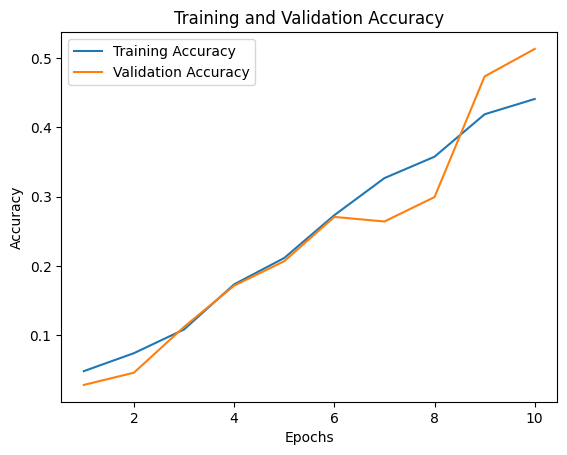

In [ ]:
import matplotlib.pyplot as plt

# Extract training and validation accuracy and loss from history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation accuracy
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


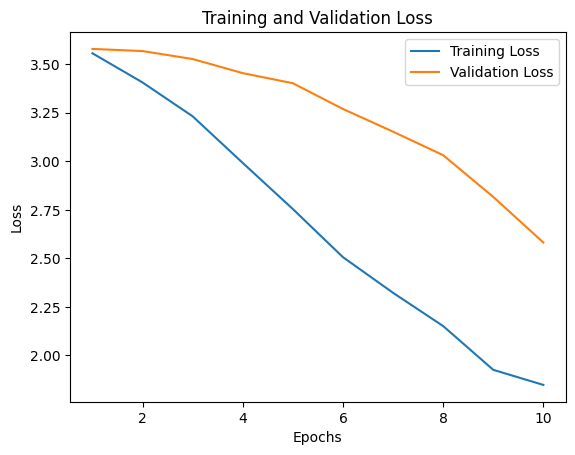

In [ ]:

# Plot training and validation loss
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score

# Generate predictions on test data
predictions = cnn_model.predict(test_generator)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Convert one-hot encoded labels back to categorical labels
true_classes = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes) * 100
print("Accuracy:", accuracy)

# Calculate precision, recall, and F1-score
precision = precision_score(true_classes, predicted_classes, average='weighted') * 100
recall = recall_score(true_classes, predicted_classes, average='weighted') * 100
f1_score = 2 * (precision * recall) / (precision + recall)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)


8/8 [==============================] - 1s 88ms/step
Accuracy: 85.7707509881423
Precision: 89.47845193892626
Recall: 85.7707509881423
F1-score: 87.58538004023865


8/8 [==============================] - 0s 22ms/step


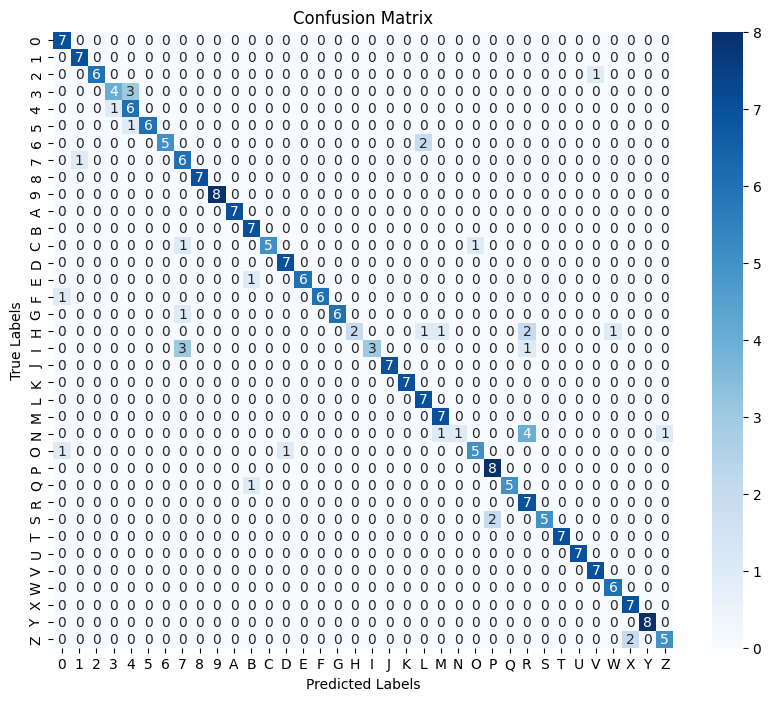

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming you have already trained your model and stored it in a variable named 'model'

# Generate predictions
predictions = cnn_model.predict(test_generator)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Extract true labels from test_generator
true_labels = test_generator.classes

# Get class names
class_names = list(test_generator.class_indices.keys())

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


1/1 [==============================] - 0s 383ms/step


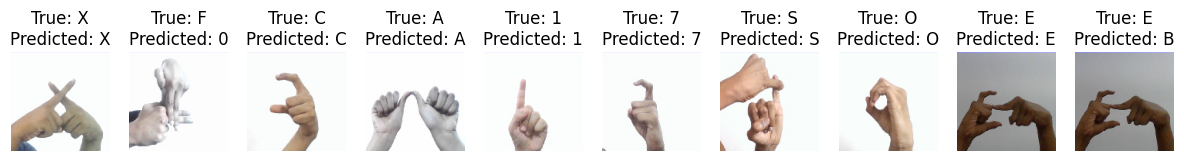

In [ ]:
import random

# Reset test generator to start from the beginning
test_generator.reset()
#print(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())
# Get a batch of test data
batch = test_generator.next()

# Extract images and labels from the batch
images, labels = batch

# Randomly select a subset of images and their corresponding labels
num_images_to_display = 10  # Adjust the number of images to display
random_indices = random.sample(range(len(images)), num_images_to_display)
selected_images = images[random_indices]
selected_labels = labels[random_indices]

# Make predictions on the selected images
predictions = cnn_model.predict(selected_images)
predicted_classes = np.argmax(predictions, axis=1)

# Display images with their predicted and true classes
plt.figure(figsize=(15, 3 * num_images_to_display))
for i in range(num_images_to_display):
    # Display the image
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(selected_images[i])

    # Get the true and predicted class names
    true_class = class_names[np.argmax(selected_labels[i])]
    pred_class = class_names[predicted_classes[i]]

    # Set the title with true and predicted classes
    plt.title(f'True: {true_class}\nPredicted: {pred_class}')
    plt.axis('off')

plt.show()

# INCEPTIONV3

In [ ]:
from tensorflow.keras.applications import InceptionV3
# Load the  inceptionv3 model pre-trained on ImageNet without the top layer
base_model1 = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the convolutional layers
base_model1.trainable = False

# Print model summary
base_model1.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 63, 63, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization_1 (Bat  (None, 63, 63, 32)           96        ['conv2d_6[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation (Activation)     (None, 63, 63, 32)           0         ['batch_normalizati

In [ ]:

inceptionv3_model = models.Sequential([
    base_model1,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(36, activation='softmax')
])


In [ ]:
inceptionv3_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               4194816   
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 36)                18468     
                                                                 
Total params: 26016068 (99.24 MB)
Trainable params: 4213284 (16.07 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [ ]:
# Define parameters
classes = 36
epochs = 10
learning_rate = 0.0001

# Compile the model
inceptionv3_model.compile(optimizer=Adam(learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history1 = inceptionv3_model.fit(train_generator,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=validation_generator,
                    shuffle=True)

Epoch 1/10
57/57 [==============================] - 15s 172ms/step - loss: 3.6165 - accuracy: 0.1593 - val_loss: 2.2525 - val_accuracy: 0.4449
Epoch 2/10
57/57 [==============================] - 6s 107ms/step - loss: 2.3709 - accuracy: 0.3445 - val_loss: 1.6658 - val_accuracy: 0.5507
Epoch 3/10
57/57 [==============================] - 6s 106ms/step - loss: 1.8319 - accuracy: 0.4658 - val_loss: 1.2397 - val_accuracy: 0.6718
Epoch 4/10
57/57 [==============================] - 6s 103ms/step - loss: 1.5352 - accuracy: 0.5485 - val_loss: 0.9965 - val_accuracy: 0.7159
Epoch 5/10
57/57 [==============================] - 6s 106ms/step - loss: 1.3532 - accuracy: 0.5959 - val_loss: 0.8851 - val_accuracy: 0.7291
Epoch 6/10
57/57 [==============================] - 6s 105ms/step - loss: 1.2266 - accuracy: 0.6273 - val_loss: 0.8452 - val_accuracy: 0.7665
Epoch 7/10
57/57 [==============================] - 6s 105ms/step - loss: 1.1503 - accuracy: 0.6477 - val_loss: 0.7466 - val_accuracy: 0.7974
Epoch

In [ ]:
inceptionv3_model.save('grey-inceptionv3-newisl.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


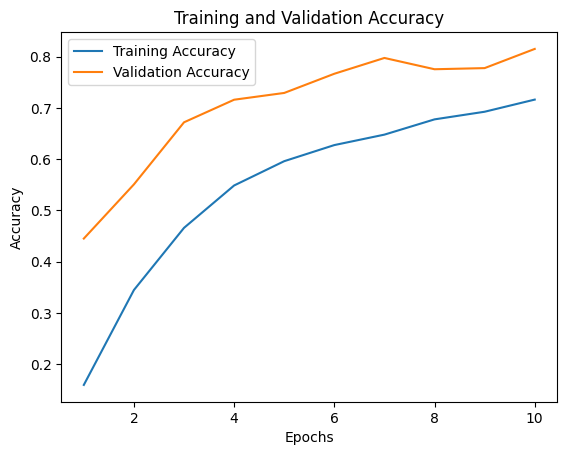

In [ ]:
import matplotlib.pyplot as plt
# Extract training and validation accuracy and loss from history
train_accuracy = history1.history['accuracy']
val_accuracy = history1.history['val_accuracy']
train_loss = history1.history['loss']
val_loss = history1.history['val_loss']

# Plot training and validation accuracy
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

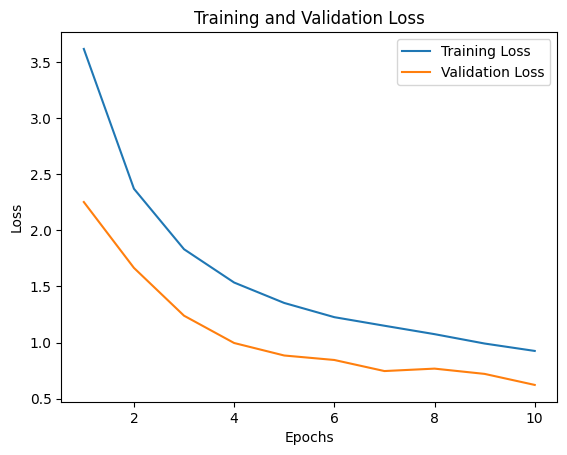

In [ ]:

# Plot training and validation loss
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Generate predictions on test data
predictions = inceptionv3_model.predict(test_generator)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Convert one-hot encoded labels back to categorical labels
true_classes = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)*100
print("Accuracy:", accuracy)

# Calculate precision, recall, and F1-score
precision = precision_score(true_classes, predicted_classes, average='weighted')*100
recall = recall_score(true_classes, predicted_classes, average='weighted')*100
f1_score = 2 * (precision * recall) / (precision + recall)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)


8/8 [==============================] - 3s 322ms/step
Accuracy: 91.699604743083
Precision: 92.93827604104284
Recall: 91.699604743083
F1-score: 92.31478548468998


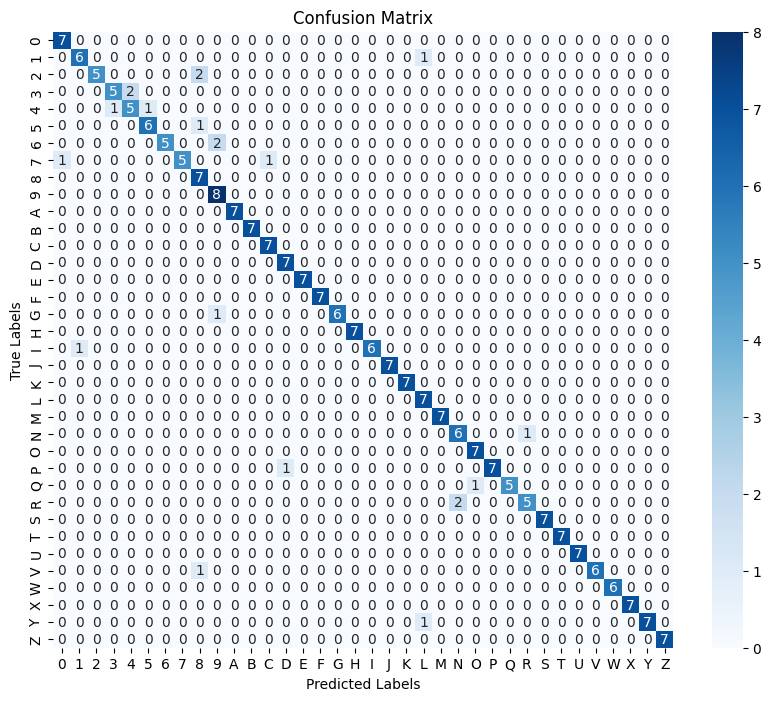

In [ ]:
# Plot confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 2s 2s/step


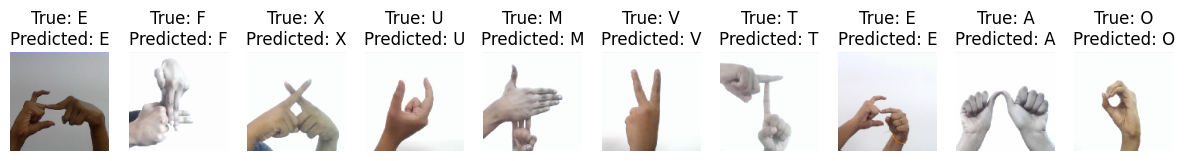

In [ ]:
import random

# Reset test generator to start from the beginning
test_generator.reset()
#print(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())
# Get a batch of test data
batch = test_generator.next()

# Extract images and labels from the batch
images, labels = batch

# Randomly select a subset of images and their corresponding labels
num_images_to_display = 10  # Adjust the number of images to display
random_indices = random.sample(range(len(images)), num_images_to_display)
selected_images = images[random_indices]
selected_labels = labels[random_indices]

# Make predictions on the selected images
predictions = inceptionv3_model.predict(selected_images)
predicted_classes = np.argmax(predictions, axis=1)

# Display images with their predicted and true classes
plt.figure(figsize=(15, 3 * num_images_to_display))
for i in range(num_images_to_display):
    # Display the image
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(selected_images[i])

    # Get the true and predicted class names
    true_class = class_names[np.argmax(selected_labels[i])]
    pred_class = class_names[predicted_classes[i]]

    # Set the title with true and predicted classes
    plt.title(f'True: {true_class}\nPredicted: {pred_class}')
    plt.axis('off')

plt.show()

# MOBILENETV2

In [ ]:
from tensorflow.keras.applications import MobileNetV2
# Load the MobileNetV2 model pre-trained on ImageNet without the top layer
base_model2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
# Freeze the convolutional layers
base_model2.trainable = False
# Print model summary
base_model2.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[

In [ ]:
MobileNetV2_model = models.Sequential([
    base_model2,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(36, activation='softmax')
])

In [ ]:
MobileNetV2_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_2 (Flatten)         (None, 20480)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               10486272  
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 36)                18468     
                                                                 
Total params: 12762724 (48.69 MB)
Trainable params: 10504740 (40.07 MB)
Non-trainable params: 2257984 (8.61 MB)
________

In [ ]:
# Define parameters
classes = 36
epochs = 10
learning_rate = 0.0001

# Compile the model
MobileNetV2_model.compile(optimizer=Adam(learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history2 = MobileNetV2_model.fit(train_generator,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=validation_generator,
                    shuffle=True)

Epoch 1/10
57/57 [==============================] - 9s 115ms/step - loss: 2.6920 - accuracy: 0.3379 - val_loss: 0.9279 - val_accuracy: 0.7533
Epoch 2/10
57/57 [==============================] - 6s 105ms/step - loss: 1.0328 - accuracy: 0.6929 - val_loss: 0.4067 - val_accuracy: 0.8855
Epoch 3/10
57/57 [==============================] - 6s 106ms/step - loss: 0.5749 - accuracy: 0.8236 - val_loss: 0.2435 - val_accuracy: 0.9339
Epoch 4/10
57/57 [==============================] - 6s 103ms/step - loss: 0.4785 - accuracy: 0.8534 - val_loss: 0.2177 - val_accuracy: 0.9405
Epoch 5/10
57/57 [==============================] - 6s 101ms/step - loss: 0.3758 - accuracy: 0.8842 - val_loss: 0.1792 - val_accuracy: 0.9581
Epoch 6/10
57/57 [==============================] - 6s 100ms/step - loss: 0.3239 - accuracy: 0.8975 - val_loss: 0.1642 - val_accuracy: 0.9559
Epoch 7/10
57/57 [==============================] - 6s 104ms/step - loss: 0.3045 - accuracy: 0.9046 - val_loss: 0.1150 - val_accuracy: 0.9758
Epoch 

In [ ]:
MobileNetV2_model.save('grey-mobilenetv2-newisl.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


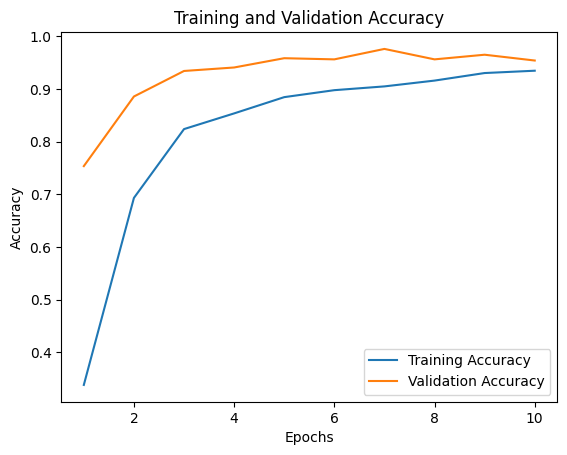

In [ ]:
import matplotlib.pyplot as plt
# Extract training and validation accuracy and loss from history
train_accuracy = history2.history['accuracy']
val_accuracy = history2.history['val_accuracy']
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']

# Plot training and validation accuracy
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


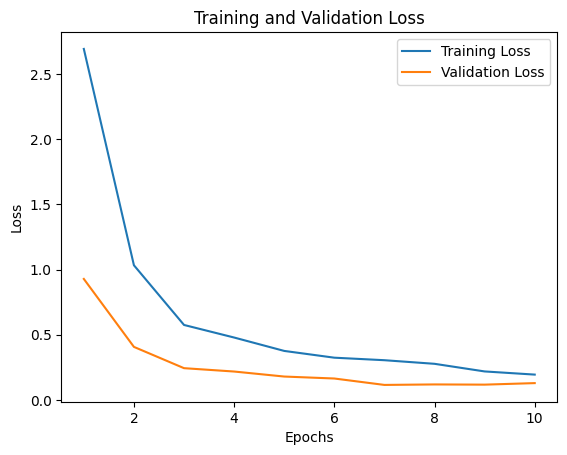

In [ ]:

# Plot training and validation loss
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Generate predictions on test data
predictions = MobileNetV2_model.predict(test_generator)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Convert one-hot encoded labels back to categorical labels
true_classes = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)*100
print("Accuracy:", accuracy)

# Calculate precision, recall, and F1-score
precision = precision_score(true_classes, predicted_classes, average='weighted')*100
recall = recall_score(true_classes, predicted_classes, average='weighted')*100
f1_score = 2 * (precision * recall) / (precision + recall)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)


8/8 [==============================] - 1s 37ms/step
Accuracy: 98.81422924901186
Precision: 99.0393061045235
Recall: 98.81422924901186
F1-score: 98.92663965380666


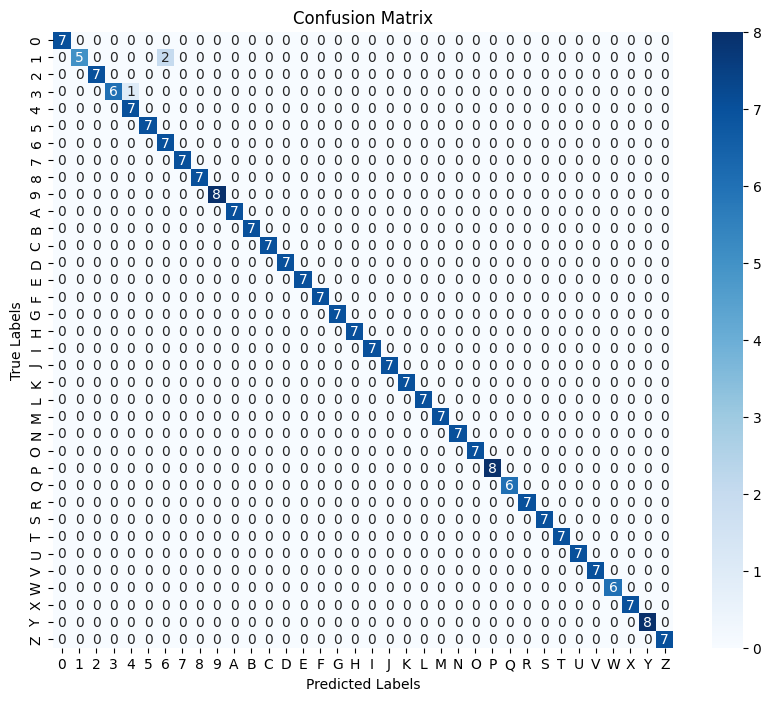

In [ ]:
# Plot confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 0s 28ms/step


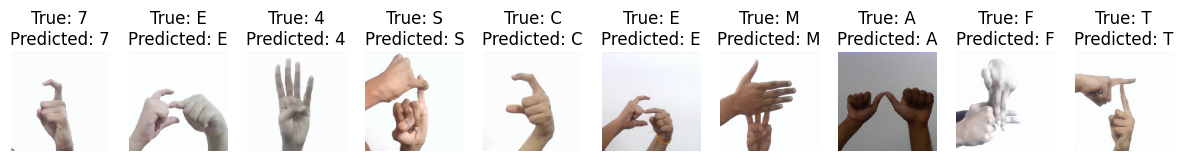

In [ ]:
import random

# Reset test generator to start from the beginning
test_generator.reset()
#print(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())
# Get a batch of test data
batch = test_generator.next()

# Extract images and labels from the batch
images, labels = batch

# Randomly select a subset of images and their corresponding labels
num_images_to_display = 10  # Adjust the number of images to display
random_indices = random.sample(range(len(images)), num_images_to_display)
selected_images = images[random_indices]
selected_labels = labels[random_indices]

# Make predictions on the selected images
predictions = inceptionv3_model.predict(selected_images)
predicted_classes = np.argmax(predictions, axis=1)

# Display images with their predicted and true classes
plt.figure(figsize=(15, 3 * num_images_to_display))
for i in range(num_images_to_display):
    # Display the image
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(selected_images[i])

    # Get the true and predicted class names
    true_class = class_names[np.argmax(selected_labels[i])]
    pred_class = class_names[predicted_classes[i]]

    # Set the title with true and predicted classes
    plt.title(f'True: {true_class}\nPredicted: {pred_class}')
    plt.axis('off')

plt.show()

# RESNET50V2

In [ ]:
from tensorflow.keras.applications import ResNet50V2
# Load the ResNet50 model pre-trained on ImageNet without the top layer
base_model3 = ResNet50V2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
# Freeze the convolutional layers
base_model3.trainable = False
# Print model summary
base_model3.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 66, 66, 64)           0         ['conv1_conv[0][0]']          
                                                                                         

In [ ]:
ResNet50V2_model = models.Sequential([
    base_model3,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(36, activation='softmax')
])

In [ ]:
ResNet50V2_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 flatten_3 (Flatten)         (None, 32768)             0         
                                                                 
 dense_6 (Dense)             (None, 512)               16777728  
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 36)                18468     
                                                                 
Total params: 40360996 (153.96 MB)
Trainable params: 16796196 (64.07 MB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
# Define parameters
classes = 36
epochs = 10
learning_rate = 0.0001

# Compile the model
ResNet50V2_model.compile(optimizer=Adam(learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history3 = ResNet50V2_model.fit(train_generator,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=validation_generator,
                    shuffle=True)

Epoch 1/10
57/57 [==============================] - 11s 145ms/step - loss: 3.3442 - accuracy: 0.3004 - val_loss: 1.2728 - val_accuracy: 0.6476
Epoch 2/10
57/57 [==============================] - 6s 112ms/step - loss: 1.5556 - accuracy: 0.5595 - val_loss: 0.7828 - val_accuracy: 0.7709
Epoch 3/10
57/57 [==============================] - 6s 108ms/step - loss: 1.0550 - accuracy: 0.6918 - val_loss: 0.5970 - val_accuracy: 0.8084
Epoch 4/10
57/57 [==============================] - 6s 109ms/step - loss: 0.9478 - accuracy: 0.7233 - val_loss: 0.4895 - val_accuracy: 0.8568
Epoch 5/10
57/57 [==============================] - 6s 107ms/step - loss: 0.7816 - accuracy: 0.7596 - val_loss: 0.4583 - val_accuracy: 0.8458
Epoch 6/10
57/57 [==============================] - 6s 107ms/step - loss: 0.7349 - accuracy: 0.7789 - val_loss: 0.3864 - val_accuracy: 0.8899
Epoch 7/10
57/57 [==============================] - 6s 108ms/step - loss: 0.6610 - accuracy: 0.8032 - val_loss: 0.3475 - val_accuracy: 0.8965
Epoch

In [ ]:
ResNet50V2_model.save('grey-resnet50v2-newisl.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


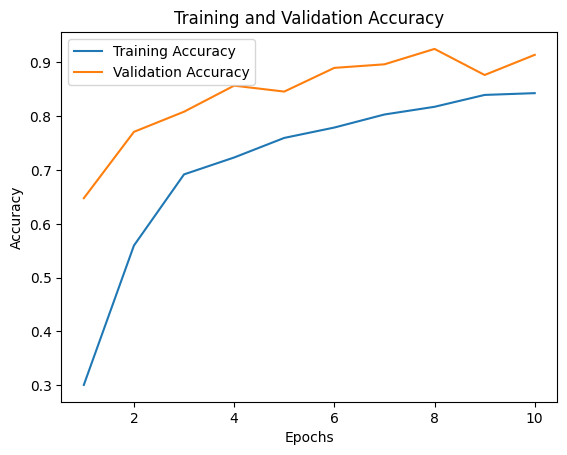

In [ ]:
import matplotlib.pyplot as plt
# Extract training and validation accuracy and loss from history
train_accuracy = history3.history['accuracy']
val_accuracy = history3.history['val_accuracy']
train_loss = history3.history['loss']
val_loss = history3.history['val_loss']

# Plot training and validation accuracy
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


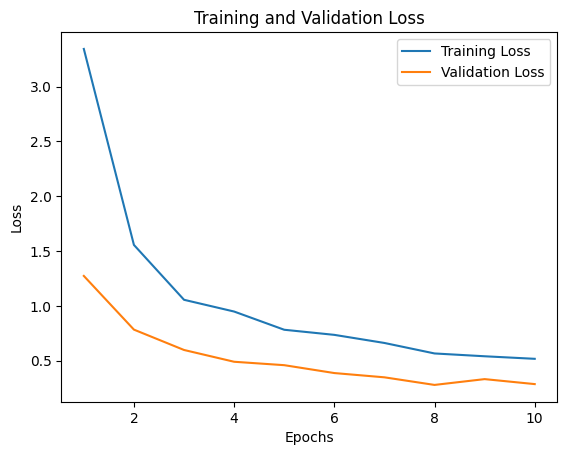

In [ ]:

# Plot training and validation loss
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Generate predictions on test data
predictions = ResNet50V2_model.predict(test_generator)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Convert one-hot encoded labels back to categorical labels
true_classes = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)*100
print("Accuracy:", accuracy)

# Calculate precision, recall, and F1-score
precision = precision_score(true_classes, predicted_classes, average='weighted')*100
recall = recall_score(true_classes, predicted_classes, average='weighted')*100
f1_score = 2 * (precision * recall) / (precision + recall)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)


8/8 [==============================] - 2s 164ms/step
Accuracy: 97.23320158102767
Precision: 97.63394817742643
Recall: 97.23320158102767
F1-score: 97.43316280917131


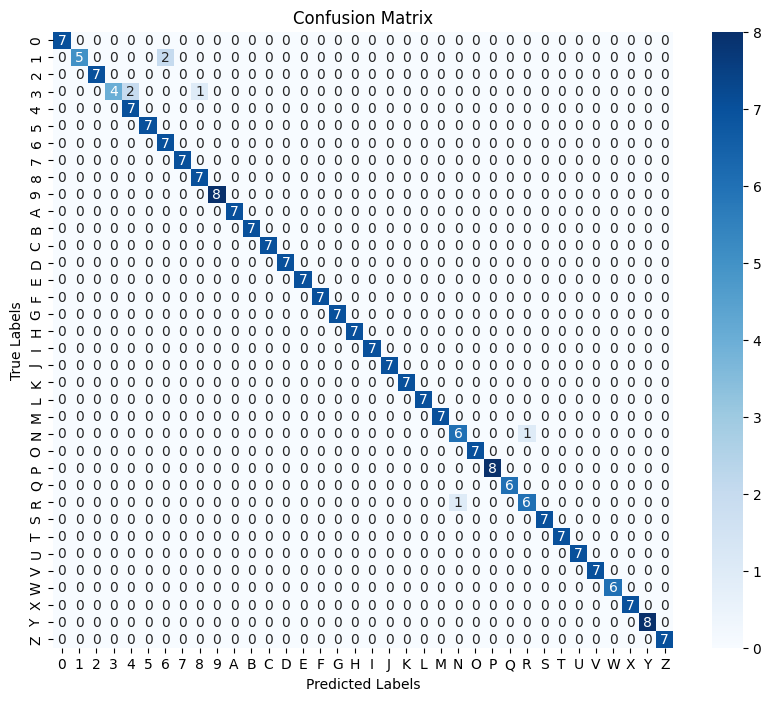

In [ ]:
# Plot confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 1s 1s/step


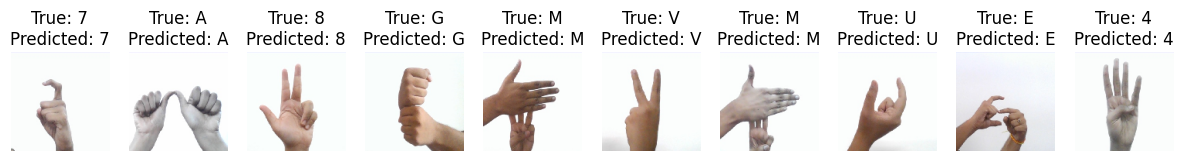

In [ ]:
import random

# Reset test generator to start from the beginning
test_generator.reset()
#print(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())
# Get a batch of test data
batch = test_generator.next()

# Extract images and labels from the batch
images, labels = batch

# Randomly select a subset of images and their corresponding labels
num_images_to_display = 10  # Adjust the number of images to display
random_indices = random.sample(range(len(images)), num_images_to_display)
selected_images = images[random_indices]
selected_labels = labels[random_indices]

# Make predictions on the selected images
predictions = ResNet50V2_model.predict(selected_images)
predicted_classes = np.argmax(predictions, axis=1)

# Display images with their predicted and true classes
plt.figure(figsize=(15, 3 * num_images_to_display))
for i in range(num_images_to_display):
    # Display the image
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(selected_images[i])

    # Get the true and predicted class names
    true_class = class_names[np.argmax(selected_labels[i])]
    pred_class = class_names[predicted_classes[i]]

    # Set the title with true and predicted classes
    plt.title(f'True: {true_class}\nPredicted: {pred_class}')
    plt.axis('off')

plt.show()

# VGG19

In [ ]:
from tensorflow.keras.applications import VGG19
# Load the vgg19 model pre-trained on ImageNet without the top layer
base_model4 = VGG19(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
# Freeze the convolutional layers
base_model4.trainable = False
# Print model summary
base_model4.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
VGG19_model = models.Sequential([
    base_model4,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(36, activation='softmax')
])

In [ ]:
VGG19_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               4194816   
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 36)                18468     
                                                                 
Total params: 24237668 (92.46 MB)
Trainable params: 4213284 (16.07 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [ ]:
# Define parameters
classes = 36
epochs = 10
learning_rate = 0.0001

# Compile the model
VGG19_model.compile(optimizer=Adam(learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history4 = VGG19_model.fit(train_generator,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=validation_generator,
                    shuffle=True)

Epoch 1/10
57/57 [==============================] - 15s 184ms/step - loss: 3.5024 - accuracy: 0.0992 - val_loss: 3.0010 - val_accuracy: 0.3568
Epoch 2/10
57/57 [==============================] - 6s 112ms/step - loss: 2.8422 - accuracy: 0.2663 - val_loss: 2.3729 - val_accuracy: 0.5859
Epoch 3/10
57/57 [==============================] - 6s 110ms/step - loss: 2.3231 - accuracy: 0.4118 - val_loss: 1.8968 - val_accuracy: 0.6850
Epoch 4/10
57/57 [==============================] - 6s 107ms/step - loss: 1.8834 - accuracy: 0.5342 - val_loss: 1.5122 - val_accuracy: 0.7731
Epoch 5/10
57/57 [==============================] - 6s 109ms/step - loss: 1.5835 - accuracy: 0.6141 - val_loss: 1.2512 - val_accuracy: 0.7753
Epoch 6/10
57/57 [==============================] - 6s 109ms/step - loss: 1.3983 - accuracy: 0.6637 - val_loss: 1.1137 - val_accuracy: 0.8062
Epoch 7/10
57/57 [==============================] - 6s 107ms/step - loss: 1.2607 - accuracy: 0.6896 - val_loss: 0.9304 - val_accuracy: 0.8546
Epoch

In [ ]:
VGG19_model.save('grey-vgg19-newisl.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


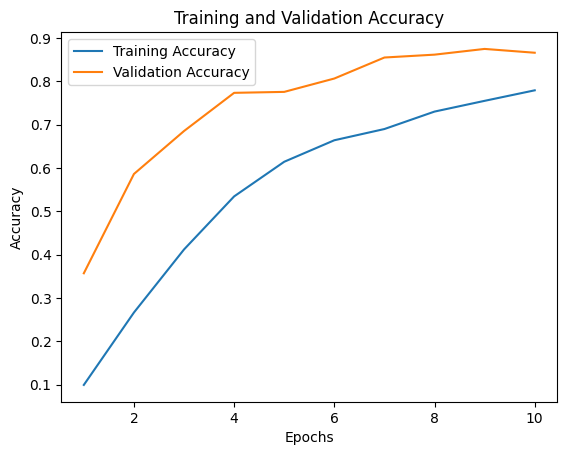

In [ ]:
import matplotlib.pyplot as plt
# Extract training and validation accuracy and loss from history
train_accuracy = history4.history['accuracy']
val_accuracy = history4.history['val_accuracy']
train_loss = history4.history['loss']
val_loss = history4.history['val_loss']

# Plot training and validation accuracy
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


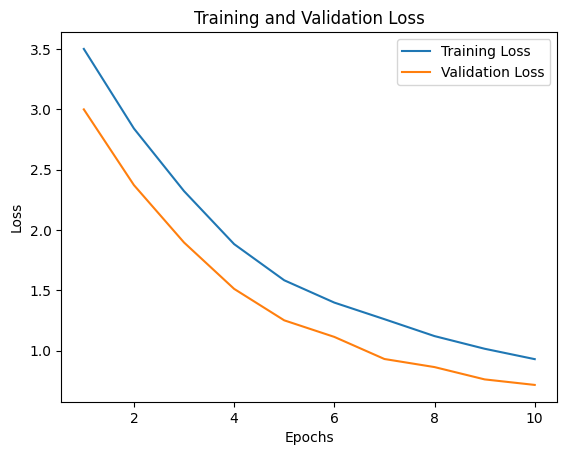

In [ ]:

# Plot training and validation loss
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Generate predictions on test data
predictions = VGG19_model.predict(test_generator)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Convert one-hot encoded labels back to categorical labels
true_classes = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)*100
print("Accuracy:", accuracy)

# Calculate precision, recall, and F1-score
precision = precision_score(true_classes, predicted_classes, average='weighted')*100
recall = recall_score(true_classes, predicted_classes, average='weighted')*100
f1_score = 2 * (precision * recall) / (precision + recall)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)


8/8 [==============================] - 4s 535ms/step
Accuracy: 96.04743083003953
Precision: 96.34387351778656
Recall: 96.04743083003953
F1-score: 96.19542378971602


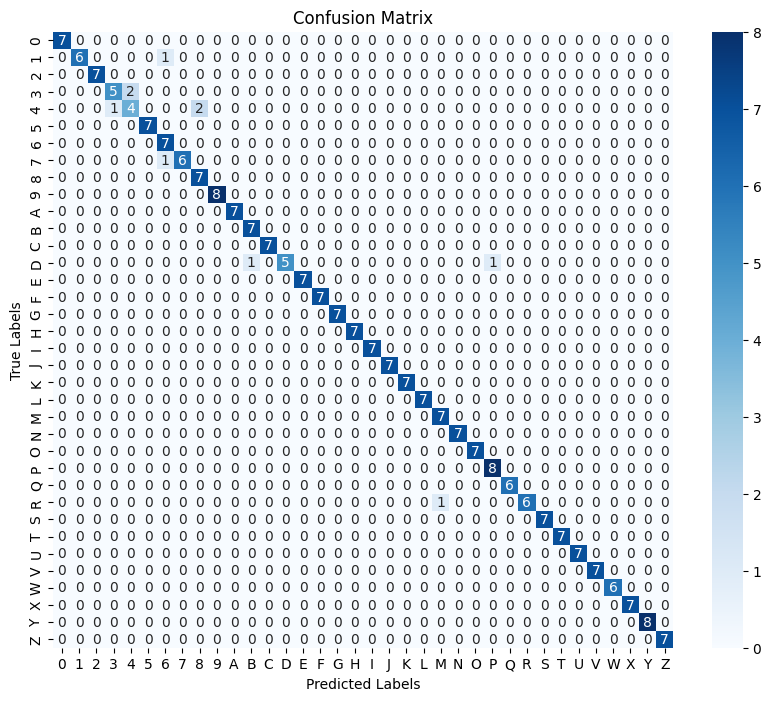

In [ ]:
# Plot confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 2s 2s/step


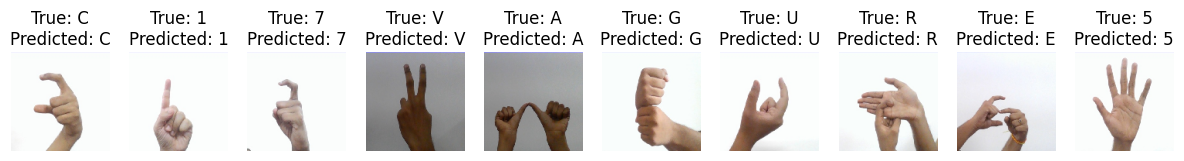

In [ ]:
import random

# Reset test generator to start from the beginning
test_generator.reset()
#print(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())
# Get a batch of test data
batch = test_generator.next()

# Extract images and labels from the batch
images, labels = batch

# Randomly select a subset of images and their corresponding labels
num_images_to_display = 10  # Adjust the number of images to display
random_indices = random.sample(range(len(images)), num_images_to_display)
selected_images = images[random_indices]
selected_labels = labels[random_indices]

# Make predictions on the selected images
predictions = VGG19_model.predict(selected_images)
predicted_classes = np.argmax(predictions, axis=1)

# Display images with their predicted and true classes
plt.figure(figsize=(15, 3 * num_images_to_display))
for i in range(num_images_to_display):
    # Display the image
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(selected_images[i])

    # Get the true and predicted class names
    true_class = class_names[np.argmax(selected_labels[i])]
    pred_class = class_names[predicted_classes[i]]

    # Set the title with true and predicted classes
    plt.title(f'True: {true_class}\nPredicted: {pred_class}')
    plt.axis('off')

plt.show()

# MODEL COMPARISON

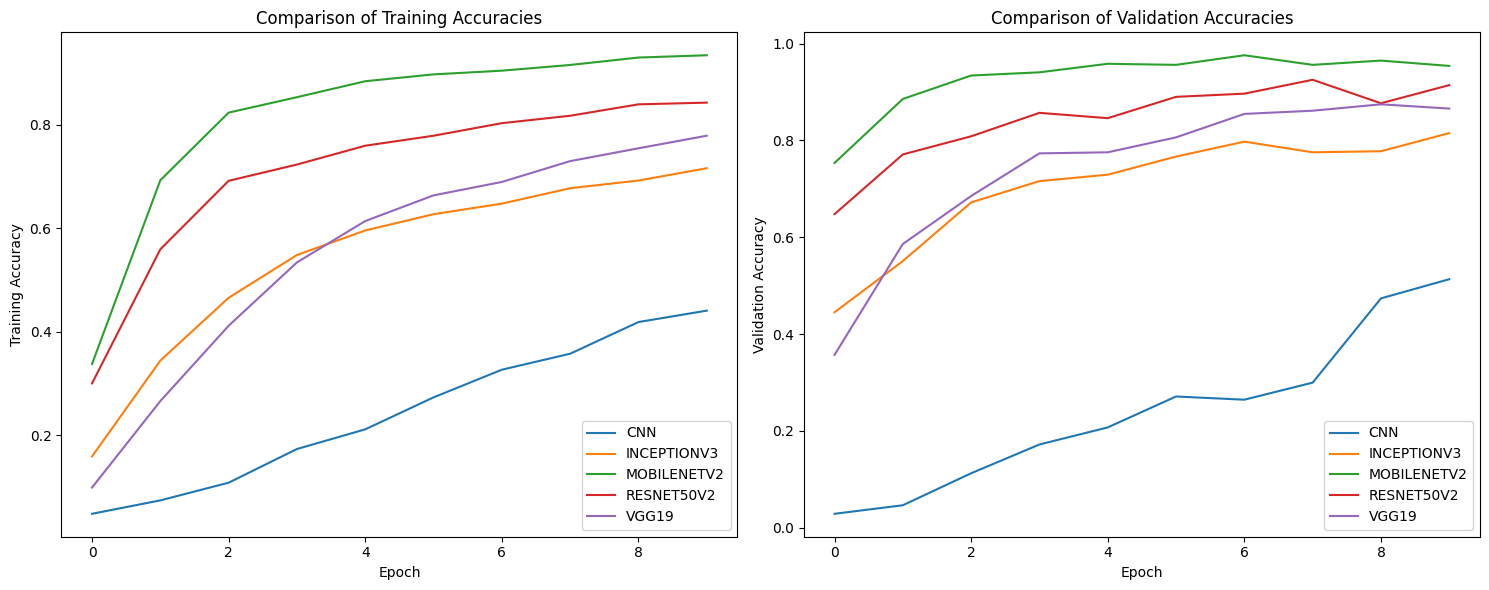

In [ ]:
import matplotlib.pyplot as plt

# Dictionary to store accuracies
train_accuracies = {}
validation_accuracies = {}

# Extract accuracies from history objects
train_accuracies['CNN'] = history.history['accuracy']
train_accuracies['INCEPTIONV3'] = history1.history['accuracy']
train_accuracies['MOBILENETV2'] = history2.history['accuracy']
train_accuracies['RESNET50V2'] = history3.history['accuracy']
train_accuracies['VGG19'] = history4.history['accuracy']

validation_accuracies['CNN'] = history.history['val_accuracy']
validation_accuracies['INCEPTIONV3'] = history1.history['val_accuracy']
validation_accuracies['MOBILENETV2'] = history2.history['val_accuracy']
validation_accuracies['RESNET50V2'] = history3.history['val_accuracy']
validation_accuracies['VGG19'] = history4.history['val_accuracy']

# Plotting the accuracies
plt.figure(figsize=(15, 6))

# Plot training accuracies
plt.subplot(1, 2, 1)
for model, acc in train_accuracies.items():
    plt.plot(acc, label=model)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Comparison of Training Accuracies')
plt.legend()

# Plot validation accuracies
plt.subplot(1, 2, 2)
for model, acc in validation_accuracies.items():
    plt.plot(acc, label=model)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Comparison of Validation Accuracies')
plt.legend()

plt.tight_layout()
plt.show()


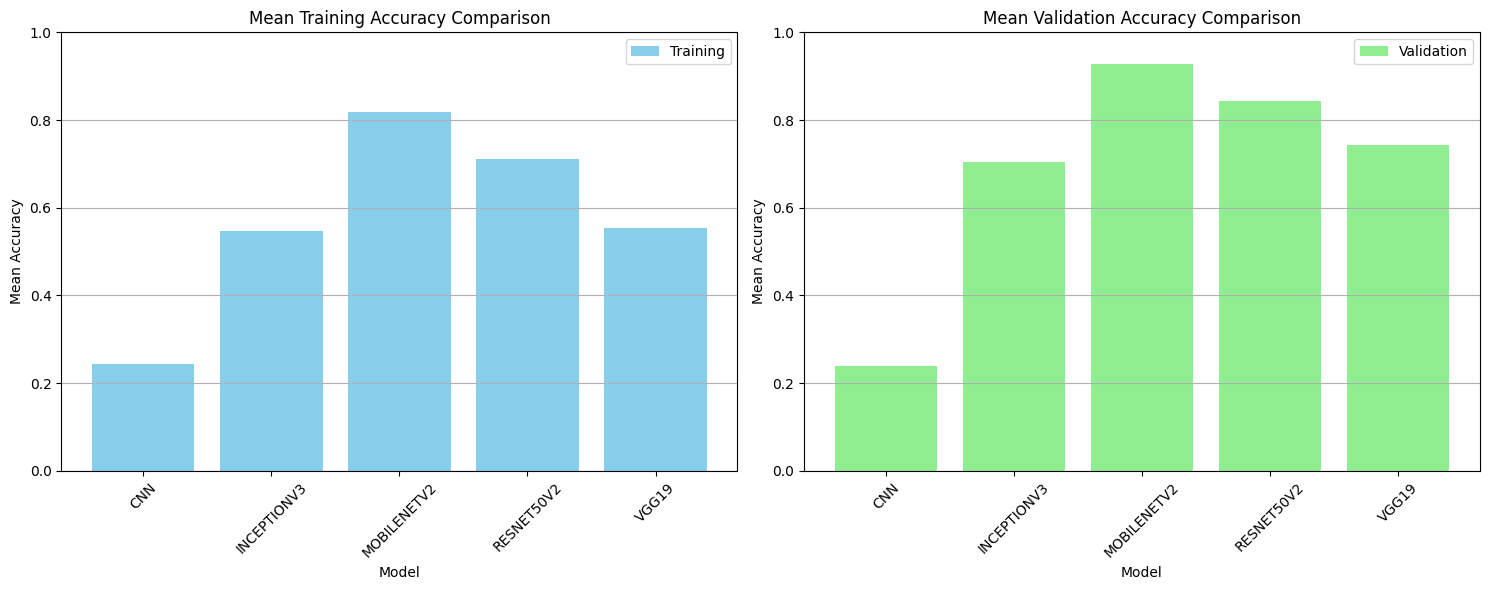

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Dictionary to store accuracies
train_accuracies = {}
validation_accuracies = {}

# Extract accuracies from history objects
train_accuracies['CNN'] = history.history['accuracy']
train_accuracies['INCEPTIONV3'] = history1.history['accuracy']
train_accuracies['MOBILENETV2'] = history2.history['accuracy']
train_accuracies['RESNET50V2'] = history3.history['accuracy']
train_accuracies['VGG19'] = history4.history['accuracy']

validation_accuracies['CNN'] = history.history['val_accuracy']
validation_accuracies['INCEPTIONV3'] = history1.history['val_accuracy']
validation_accuracies['MOBILENETV2'] = history2.history['val_accuracy']
validation_accuracies['RESNET50V2'] = history3.history['val_accuracy']
validation_accuracies['VGG19'] = history4.history['val_accuracy']

# Calculate mean accuracies
train_means = [np.mean(acc) for acc in train_accuracies.values()]
validation_means = [np.mean(acc) for acc in validation_accuracies.values()]

# Plotting bar plots for mean training and validation accuracies
plt.figure(figsize=(15, 6))

# Plot mean training accuracies
plt.subplot(1, 2, 1)
plt.bar(np.arange(len(train_accuracies)), train_means, color='skyblue', label='Training')
plt.xlabel('Model')
plt.ylabel('Mean Accuracy')
plt.title('Mean Training Accuracy Comparison')
plt.xticks(np.arange(len(train_accuracies)), train_accuracies.keys(), rotation=45)
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y')

# Plot mean validation accuracies
plt.subplot(1, 2, 2)
plt.bar(np.arange(len(validation_accuracies)), validation_means, color='lightgreen', label='Validation')
plt.xlabel('Model')
plt.ylabel('Mean Accuracy')
plt.title('Mean Validation Accuracy Comparison')
plt.xticks(np.arange(len(validation_accuracies)), validation_accuracies.keys(), rotation=45)
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y')

plt.tight_layout()
plt.show()


8/8 [==============================] - 1s 69ms/step - loss: 0.3144 - accuracy: 0.9605


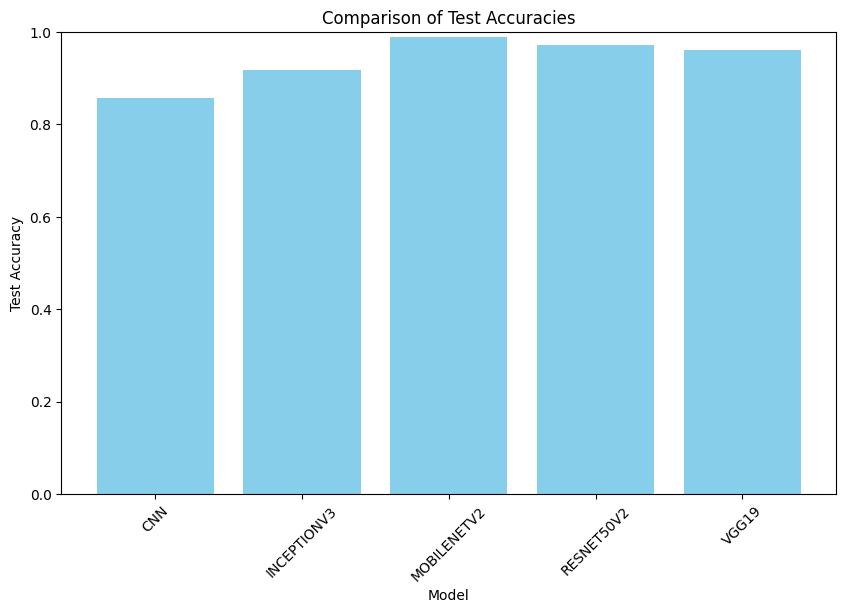

In [ ]:
# Dictionary to store test accuracies
test_accuracies = {}

# Evaluate each model on the test data
test_accuracies['CNN'] = cnn_model.evaluate(test_generator)[1]
test_accuracies['INCEPTIONV3'] = inceptionv3_model.evaluate(test_generator)[1]
test_accuracies['MOBILENETV2'] = MobileNetV2_model.evaluate(test_generator)[1]
test_accuracies['RESNET50V2'] = ResNet50V2_model.evaluate(test_generator)[1]
test_accuracies['VGG19'] = VGG19_model.evaluate(test_generator)[1]

# Plotting the test accuracies
plt.figure(figsize=(10, 6))
plt.bar(test_accuracies.keys(), test_accuracies.values(), color='skyblue')
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.title('Comparison of Test Accuracies')
plt.xticks(rotation=45)
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1
plt.show()
